https://towardsdatascience.com/4-different-approaches-for-time-series-analysis-7e2364fadcb9

In [46]:
import pandas as pd
df = pd.read_csv('source/tourist_arrivals.csv')
df.head()

,date,value
0,'2012-01-01',2343290
1,'2012-02-01',10468842
2,'2012-03-01',13908950
3,'2012-04-01',18456089
4,'2012-05-01',20294254


In [47]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
ts = df['value']

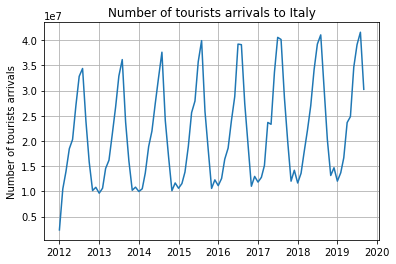

In [48]:
import matplotlib.pyplot as plt
plt.plot(ts)
plt.title('Number of tourists arrivals to Italy')
plt.ylabel('Number of tourists arrivals')
plt.grid()
plt.show()

In [49]:
ts_train = ts[:'2019-03-01']
ts_test = ts['2019-04-01':]

In [50]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [51]:
check_stationarity(ts_train)

The series is NOT stationary


In [52]:
ts_diff = ts_train.diff()
ts_diff.dropna(inplace=True)
check_stationarity(ts_diff)

The series is stationary


In [53]:
d = 1

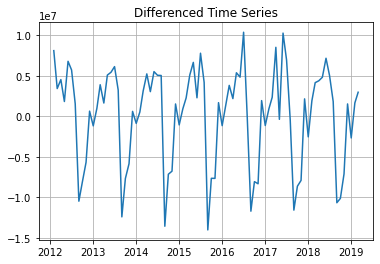

In [54]:
plt.plot(ts_diff)
plt.title('Differenced Time Series')
plt.grid()
plt.show()

c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


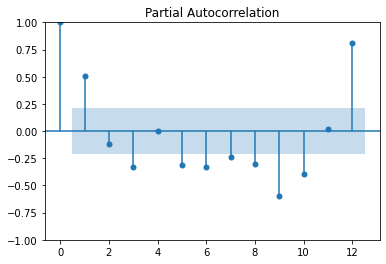

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(ts_diff, lags =12)
plt.show()

In [56]:
p = 10

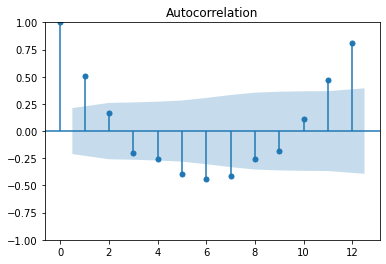

In [57]:
plot_acf(ts_diff, lags =12)
plt.show()

In [58]:
q = 7

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(ts_train, order=(p,d,q))
model_fit = model.fit()

c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

In [60]:
n_test = ts_test.shape[0]
ts_pred = model_fit.forecast(steps=n_test)

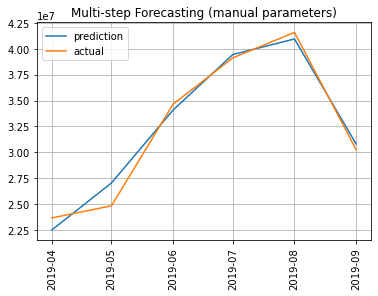

In [61]:
plt.plot(ts_pred, label='prediction')
plt.plot(ts_test, label='actual')
plt.title('Multi-step Forecasting (manual parameters)')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

In [62]:
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(ts_pred, ts_test)/(np.max(ts_test)-np.min(ts_test))
nrmse

0.061856362384958716

In [63]:
ts_train_step = ts_train
ts_pred_step = pd.Series()
for i in range(0, n_test):
    model_step = SARIMAX(ts_train_step, order=(p,d,q))
    model_step_fit = model_step.fit()
    current_pred = model_step_fit.forecast(steps=1)
    ts_train_step = ts_train_step.append(current_pred)
    ts_pred_step = ts_pred_step.append(current_pred)

C:\Users\luisalves\AppData\Local\Temp\ipykernel_21312\4187094384.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ts_pred_step = pd.Series()
c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters

In [64]:
nrmse = rmse(ts_pred_step, ts_test)/(np.max(ts_test)-np.min(ts_test))
nrmse

0.06204056223706963

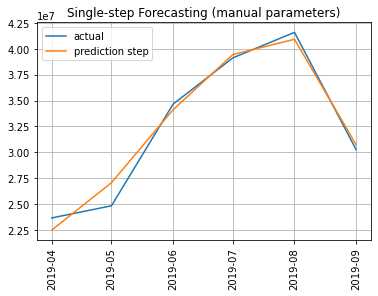

In [65]:
plt.plot(ts_test, label='actual')
plt.plot(ts_pred_step, label='prediction step')
plt.title('Single-step Forecasting (manual parameters)')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

In [66]:
import pmdarima as pm
stepwise_model = pm.auto_arima(ts_train,start_p=1, d=1, start_q=1,
                            max_p=12, max_q=12,
                            m=12,
                            seasonal=True, stationary=False,
                            information_criterion='aic',
                            stepwise=False,
                            suppress_warnings=True)
stepwise_model.fit(ts_train)

c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,1,0)(1,1,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [67]:
ARIMA(order=(1, 1, 3), seasonal_order=(0, 1, 0, 12), suppress_warnings=True)

NameError: name 'ARIMA' is not defined

In [68]:
ts_pred_auto = stepwise_model.predict(n_periods=n_test)

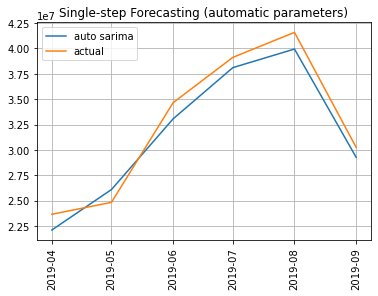

In [69]:
plt.plot(ts_test.index,ts_pred_auto, label='auto sarima')
plt.plot(ts_test, label='actual')
plt.title('Single-step Forecasting (automatic parameters)')
plt.grid()
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [70]:
nrmse = rmse(ts_pred_auto, ts_test)/(np.max(ts_test)-np.min(ts_test))
nrmse

0.07632379472151295

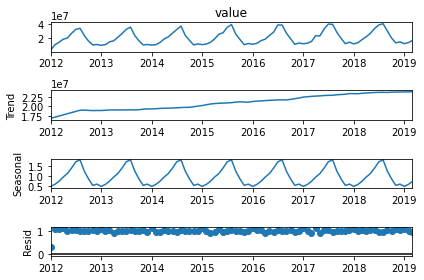

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_decomposed = seasonal_decompose(ts_train,model='multiplicative',extrapolate_trend=True)
ts_trend = ts_decomposed.trend
ts_seasonal = ts_decomposed.seasonal
ts_residual = ts_decomposed.resid
ts_decomposed.plot()
plt.show()

In [72]:
check_stationarity(ts_trend)

The series is NOT stationary


In [73]:
ts_trend_diff = ts_trend.diff()
ts_trend_diff.dropna(inplace=True)
check_stationarity(ts_trend_diff)

The series is stationary


In [74]:
d = 1

In [75]:
stepwise_model = pm.auto_arima(ts_trend,start_p=1, d=1, start_q=1,
                            max_p=12, max_q=12,
                            m=12,
                            seasonal=False, stationary=False,
                            information_criterion='aic',
                            stepwise=False,
                            suppress_warnings=True)
stepwise_model.fit(ts_trend)

c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


ARIMA(order=(4, 1, 1), scoring_args={}, suppress_warnings=True)

In [76]:
trend_pred_auto = stepwise_model.predict(n_periods=n_test)

In [77]:
check_stationarity(ts_seasonal)

The series is stationary


In [78]:
d = 0

In [79]:
stepwise_model = pm.auto_arima(ts_seasonal,start_p=1, d=0, start_q=1,
                            max_p=12, max_q=12,
                            m=12,
                            seasonal=True, stationary=True,
                            information_criterion='aic',
                            stepwise=False,
                            suppress_warnings=True)
stepwise_model.fit(ts_seasonal)
seasonal_pred_auto = stepwise_model.predict(n_periods=n_test)

In [80]:
ts_pred_decompose = trend_pred_auto * seasonal_pred_auto

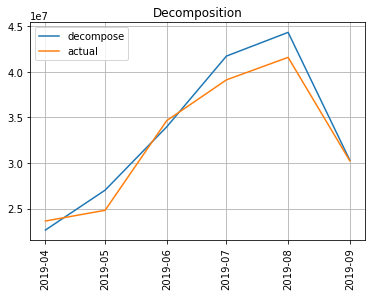

In [81]:
plt.plot(ts_test.index, ts_pred_decompose, label='decompose')
plt.plot(ts_test, label='actual')
plt.title('Decomposition')
plt.grid()
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [82]:
nrmse = rmse(ts_pred_decompose, ts_test)/(np.max(ts_test)-np.min(ts_test))
nrmse

0.10333835787758565